In [73]:
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model

import math

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict

%matplotlib inline
import matplotlib.pyplot as plt

RANDOM_SEED = 6    # Set a random seed for reproducibility!

In [2]:
features_df = pd.read_csv(
    "training_set_features.csv", 
    index_col="respondent_id"
)
labels_df = pd.read_csv(
    "training_set_labels.csv", 
    index_col="respondent_id"
)
print("features_df.shape", features_df.shape)
features_df.head()

features_df.shape (26707, 35)


,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [3]:
np.testing.assert_array_equal(features_df.index.values, labels_df.index.values)

In [99]:
numeric_cols = features_df.columns[features_df.dtypes != "object"].values

numeric_preprocessing_steps = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('simple_imputer', SimpleImputer(strategy='median'))
])

# create the preprocessor stage of final pipeline
# each entry in the transformer list is a tuple of
# (name you choose, sklearn transformer, list of columns)
preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", numeric_preprocessing_steps, numeric_cols)
    ],
    remainder = "drop"
)

estimators = MultiOutputClassifier(
    #estimator=LogisticRegression(penalty="l2", C=1) #Uncomment to use Log reg
    estimator=RandomForestClassifier(random_state=0) #100 trees default, Uncomment to use Random Tree 
)
estimators = MultiOutputRegressor(
    estimator = linear_model.Lasso(alpha=0.5) #Can change Alpha and weight of regularization term
)

full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("estimators", estimators),
])

In [18]:
#Training/testing on all data
X_train, X_eval, y_train, y_eval = train_test_split(
    features_df,
    labels_df,
    test_size=0.33,
    shuffle=True,
    stratify=labels_df,
    random_state=RANDOM_SEED
)

In [6]:
# Train model on all data
full_pipeline.fit(X_train, y_train)
preds = full_pipeline.predict_proba(X_eval)

y_preds = pd.DataFrame(
    {
        "h1n1_vaccine": preds[0][:, 1],
        "seasonal_vaccine": preds[1][:, 1],
    },
    index = y_eval.index)
#Overall MSE and ROC
print(mean_squared_error(y_eval['h1n1_vaccine'], y_preds['h1n1_vaccine']))
print(roc_auc_score(y_eval['h1n1_vaccine'], y_preds['h1n1_vaccine']))

0.12069926994728068
0.8277931524204213


In [30]:
#Get data on each race:
black = features_df.loc[features_df['race'] == "Black"]
black_labels = labels_df.iloc[[i for i in list(black.index)]]
print(len(black_labels))

white = features_df.loc[features_df['race'] == "White"]
white_labels = labels_df.iloc[[i for i in list(white.index)]]
print(len(white_labels))

hispanic = features_df.loc[features_df['race'] == "Hispanic"]
hispanic_labels = labels_df.iloc[[i for i in list(hispanic.index)]]
print(len(hispanic_labels))

2118
21222
1755


In [8]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )
    ax.legend(["White", "One-to-One","Black", "Hispanic"])

In [100]:
#Train and test per each race
races = [white, black, hispanic]
races_labels = [white_labels, black_labels, hispanic_labels]
names = ["White", "Black", "Hispanic"]
for race in range(len(races)):
    X_train, X_eval, y_train, y_eval = train_test_split(
    races[race],
    races_labels[race],
    test_size=0.33,
    shuffle=True,
    stratify=races_labels[race],
    random_state=RANDOM_SEED
    )
    full_pipeline.fit(X_train, y_train)
    #preds = cross_val_predict(full_pipeline, X_eval, y_eval, cv=5, method='predict_proba') #For Log and Random Forest
    preds = cross_val_predict(full_pipeline, X_eval, y_eval, cv=5, method='predict') #For Lasso

#y_preds for Random forest and Log reg
#     y_preds = pd.DataFrame(
#     {
#         "h1n1_vaccine": preds[0][:, 1],
#         "seasonal_vaccine": preds[1][:, 1],
#     },
#    index = y_eval.index)

#y_preds for Lasso
    y_preds = pd.DataFrame(
    {
        "h1n1_vaccine": preds[:, 0],
        "seasonal_vaccine": preds[:,1],
    },
    index = y_eval.index)
    
    print(names[race], "MSE", mean_squared_error(y_eval['h1n1_vaccine'], y_preds['h1n1_vaccine'])) #Not super meaningful for Lasso
    print(names[race], "AUC h1n1", roc_auc_score(y_eval['h1n1_vaccine'], y_preds['h1n1_vaccine']))
    print(names[race], "AUC Seasonal", roc_auc_score(y_eval['seasonal_vaccine'], y_preds['seasonal_vaccine']))
    
    # fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))

    # plot_roc(
    #     y_eval['h1n1_vaccine'], 
    #     y_preds['h1n1_vaccine'], 
    #     'h1n1_vaccine',
    #     ax=ax[0]
    # )
    # plot_roc(
    #     y_eval['seasonal_vaccine'], 
    #     y_preds['seasonal_vaccine'], 
    #     'seasonal_vaccine',
    #     ax=ax[1]
    # )
    # fig.tight_layout()


    

               h1n1_vaccine  seasonal_vaccine
respondent_id                                
19833              0.213457          0.489202
24999              0.213457          0.489202
2173               0.213457          0.489202
15616              0.213457          0.489202
610                0.213457          0.489202
...                     ...               ...
24339              0.219665          0.486081
24749              0.219665          0.486081
9711               0.219665          0.486081
16847              0.219665          0.486081
14399              0.219665          0.486081

[7004 rows x 2 columns]
White MSE 0.17106382656987232
White AUC h1n1 0.479124048845344
White AUC Seasonal 0.4846905004757328
               h1n1_vaccine  seasonal_vaccine
respondent_id                                
12524              0.153846          0.347048
6992               0.153846          0.347048
16390              0.153846          0.347048
18471              0.153846          0.347048


0.11992361134470059
WHITE 0.8368497097248696
BLACK 0.7332255979314803
HISPANIC 0.7460163128612326
WHITE 0.8423204338323667
BLACK 0.8136833588060773
HISPANIC 0.75116300645452


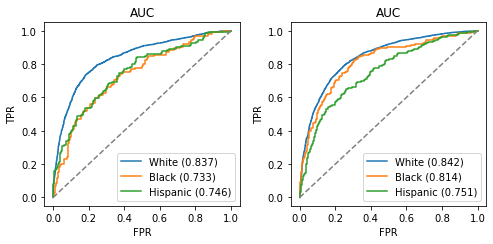

In [86]:
#Plot results of above on 1 graph
#White as eval, for plotting everyone on same graph
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))

fpr, tpr, thresholds = roc_curve(y_eval['h1n1_vaccine'], y_preds['h1n1_vaccine'])
ax[0].plot(fpr, tpr)
fpr, tpr, thresholds = roc_curve(y_eval_black['h1n1_vaccine'], y_preds_black['h1n1_vaccine'])
ax[0].plot(fpr, tpr)
fpr, tpr, thresholds = roc_curve(y_eval_hispanic['h1n1_vaccine'], y_preds_hispanic['h1n1_vaccine'])
ax[0].plot(fpr, tpr)
ax[0].plot([0, 1], [0, 1], color='grey', linestyle='--')
ax[0].set_ylabel('TPR')
ax[0].set_xlabel('FPR')
ax[0].set_title(
    "AUC"
)
ax[0].legend(["White (0.837)","Black (0.733)", "Hispanic (0.746)"])

fpr, tpr, thresholds = roc_curve(y_eval['seasonal_vaccine'], y_preds['seasonal_vaccine'])
ax[1].plot(fpr, tpr)
fpr, tpr, thresholds = roc_curve(y_eval_black['seasonal_vaccine'], y_preds_black['seasonal_vaccine'])
ax[1].plot(fpr, tpr)
fpr, tpr, thresholds = roc_curve(y_eval_hispanic['seasonal_vaccine'], y_preds_hispanic['seasonal_vaccine'])
ax[1].plot(fpr, tpr)
ax[1].plot([0, 1], [0, 1], color='grey', linestyle='--')
ax[1].set_ylabel('TPR')
ax[1].set_xlabel('FPR')
ax[1].set_title(
    "AUC"
)
ax[1].legend(["White (0.842)","Black (0.814)", "Hispanic (0.751)"])
fig.tight_layout()

In [24]:
#Data for each gender:
female = features_df.loc[features_df['sex'] == "Female"]
female_labels = labels_df.iloc[[i for i in list(female.index)]]
print(len(female_labels))

male = features_df.loc[features_df['sex'] == "Male"]
male_labels = labels_df.iloc[[i for i in list(male.index)]]
print(len(male_labels))

15858
10849


In [25]:
#Train/test for each gender 
genders = [female, male]
genders_labels = [female_labels, male_labels]
names = ["Female", "Male"]
for gender in range(len(genders)):
    X_train, X_eval, y_train, y_eval = train_test_split(
        genders[gender],
        genders_labels[gender],
        test_size=0.33,
        shuffle=True,
        stratify=genders_labels[gender],
        random_state=RANDOM_SEED
    )
    full_pipeline.fit(X_train, y_train)
    preds = cross_val_predict(full_pipeline, X_eval, y_eval, cv=5, method='predict_proba')
    #preds = full_pipeline.predict_proba(X_eval)
    y_preds = pd.DataFrame(
        {
            "h1n1_vaccine": preds[0][:, 1],
            "seasonal_vaccine": preds[1][:, 1],
        },
        index = y_eval.index)
    #Overall MSE and ROC
    print(names[gender], mean_squared_error(y_eval['h1n1_vaccine'], y_preds['h1n1_vaccine']))
    print(names[gender], roc_auc_score(y_eval['h1n1_vaccine'], y_preds['h1n1_vaccine']))
    print(names[gender], roc_auc_score(y_eval['seasonal_vaccine'], y_preds['seasonal_vaccine']))
    
    # plot_roc(
    #     y_eval['h1n1_vaccine'], 
    #     y_preds['h1n1_vaccine'], 
    #     'h1n1_vaccine',
    #     ax=ax[0]
    # )
    # plot_roc(
    #     y_eval['seasonal_vaccine'], 
    #     y_preds['seasonal_vaccine'], 
    #     'seasonal_vaccine',
    #     ax=ax[1]
    # )

#Plotting:
# fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))

# fpr, tpr, thresholds = roc_curve(y_eval['h1n1_vaccine'], y_preds['h1n1_vaccine'])
# ax[0].plot(fpr, tpr)
# fpr, tpr, thresholds = roc_curve(y_eval_male['h1n1_vaccine'], y_preds_male['h1n1_vaccine'])
# ax[0].plot(fpr, tpr)
# ax[0].plot([0, 1], [0, 1], color='grey', linestyle='--')
# ax[0].set_ylabel('TPR')
# ax[0].set_xlabel('FPR')
# ax[0].set_title(
#     "AUC"
# )
# ax[0].legend(["Female (0.838)","Male (0.792)"])

# fpr, tpr, thresholds = roc_curve(y_eval['seasonal_vaccine'], y_preds['seasonal_vaccine'])
# ax[1].plot(fpr, tpr)
# fpr, tpr, thresholds = roc_curve(y_eval_male['seasonal_vaccine'], y_preds_male['seasonal_vaccine'])
# ax[1].plot(fpr, tpr)
# ax[1].plot([0, 1], [0, 1], color='grey', linestyle='--')
# ax[1].set_ylabel('TPR')
# ax[1].set_xlabel('FPR')
# ax[1].set_title(
#     "AUC"
# )
# ax[1].legend(["Female (0.833)","Male (0.820)"])
# fig.tight_layout()
# fig.tight_layout()

Female 0.12692582453009024
Female 0.8179687941086549
Female 0.8193625776080087
Male 0.13143693614050853
Male 0.7639431695341672
Male 0.8017188861271972
